# G4Hive performance analysis

Let's look at some measurements of G4Hive jobs for different number of threads and make some plots. We want to look at how memory and throughput scale with the number of threads. We also want to look at the timing of algorithms in the job.

In [1]:
import os
import csv
import re
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
%matplotlib notebook

## Prepare the data 

The results come in the form of log files. A memory monitor runs alongside the job to measure its memory consumption as a function of time. The job also dumps a timeline log which shows the start and end times of every algorithm per thread and event slot. From these files we can extract everything we need.

In [2]:
ls results/

log.10_0_500.log       mem.10_0_500.csv       timeline.10_0_500.log
log.12_0_500.log       mem.12_0_500.csv       timeline.12_0_500.log
log.14_0_500.log       mem.14_0_500.csv       timeline.14_0_500.log
log.16_0_500.log       mem.16_0_500.csv       timeline.16_0_500.log
log.18_0_500.log       mem.18_0_500.csv       timeline.18_0_500.log
log.1_0_50.log         mem.1_0_50.csv         timeline.1_0_50.log
log.20_0_500.log       mem.20_0_500.csv       timeline.20_0_500.log
log.22_0_500.log       mem.22_0_500.csv       timeline.22_0_500.log
log.24_0_500.log       mem.24_0_500.csv       timeline.24_0_500.log
log.26_0_500.log       mem.26_0_500.csv       timeline.26_0_500.log
log.28_0_500.log       mem.28_0_500.csv       timeline.28_0_500.log
log.2_0_100.log        mem.2_0_100.csv        timeline.2_0_100.log
log.30_0_500.log       mem.30_0_500.csv       timeline.30_0_500.log
log.3_0_150.log        mem.3_0_150.csv        timeline.3_0_150.log
log.4_0_200.log        mem.4_0_200.csv        timeli

In [3]:
all_files = os.listdir('results')
mem_files = [f for f in all_files if f.startswith('mem.')]
time_files = [f for f in all_files if f.startswith('timeline.')]

Let's take a peek at the format of these files

In [4]:
def peek_file(file):
    print('%s:' % file)
    with open(os.path.join('results', file)) as f:
        for line in f.readlines()[0:3]:
            print('    %s' % line.strip())
            
peek_file(mem_files[-1])
peek_file(time_files[-1])

mem.9_0_450.csv:
    1464559661813587469,2816
    1464559662864968958,17944
    1464559663911720079,56524
timeline.9_0_450.log:
    1464559661726266578
    #start end algorithm thread slot event
    1464559843492100874 1464559843492102592 AthRegSeq 1720821504 0 0


Now we define some functions for parsing out the measurements from the log files.
I use numpy's genfromtxt to do most of the parsing:
http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.genfromtxt.html

In [5]:
def parse_job_info(file_name):
    """Parses out basic job info from the file-name.
    Returns nThread, nProc, nEvent
    """
    config_str = file_name.split('.')[1]
    nThread, nProc, nEvent = config_str.split('_')
    return int(nThread), int(nProc), int(nEvent)

def parse_mem_file(mem_file):
    """Use numpy to parse the memory monitoring log file.
    Returns a structured 2D array of monitoring data."""
    return np.genfromtxt(os.path.join('results', mem_file),
                         delimiter=',', dtype='i8,i4',
                         names=['times', 'mems'])

def parse_time_file(time_file):
    """Extract job start and end time from a time log file"""
    with open(os.path.join('results', time_file)) as f:
        lines = f.readlines()
    start_time, end_time = int(lines[0]), int(lines[-1])
    return start_time, end_time

def parse_timeline(timeline):
    """Parse alg timing results for one job with numpy"""
    results = np.genfromtxt(os.path.join('results', timeline),
                            skip_header=2, skip_footer=1,
                            dtype='i8,i8,U15,i4,i4,i4',
                            names=['starts', 'ends', 'algs',
                                   'tids', 'slots', 'events'])
    results.sort(order='starts')
    return results

In [6]:
class JobResult:
    """A structure to hold all the measurements associated with one job"""
    def __init__(self, nThread, nProc, nEvent):
        self.nThread, self.nProc, self.nEvent = nThread, nProc, nEvent

Finally, we will parse all of the log files and store the results in these JobResult objects in one single list.

In [7]:
job_results = []
for mem_file, time_file in zip(mem_files, time_files):
    nThread, nProc, nEvent = parse_job_info(mem_file)
    assert((nThread, nProc, nEvent) == parse_job_info(time_file))
    j = JobResult(nThread, nProc, nEvent)
    j.times_mems = parse_mem_file(mem_file)
    # Currently, I'm dumping the start/end times into the timeline file
    j.start_time, j.end_time = parse_time_file(time_file)
    j.timeline_results = parse_timeline(time_file)
    job_results.append(j)

# Sort results by nThread
job_results.sort(key=lambda j: j.nThread)

## Job timing
Let's look at some general timing info about the jobs

In [8]:
def get_job_time(job):
    """Length of full job in seconds"""
    return (job.end_time - job.start_time)*1e-9

def get_evloop_start_time(job):
    """Raw timestamp (in nanoseconds) of the start of the event loop"""
    return job.timeline_results['starts'].min()

def get_evloop_end_time(job):
    """Raw timestamp (in nanoseconds) of the end of the event loop"""
    return job.timeline_results['ends'].max()

def get_evloop_time(job):
    """Duration of the event loop in seconds"""
    return (get_evloop_end_time(job) - get_evloop_start_time(job))*1e-9

def get_initialization_time(job):
    """Duration of job initialization in seconds"""
    events_start = get_evloop_start_time(job)
    return (events_start - job.start_time)*1e-9

def get_finalization_time(job):
    """Duration of job finalization in seconds"""
    events_end = get_evloop_end_time(job)
    return (job.end_time - events_end)*1e-9

In [9]:
# Print some basic timing info
print('Threads Events Job-time Init-time Loop-time Final-time')
for j in job_results:
    print('{0:7d} {1:6d} {2:8.1f} {3:9.1f} {4:9.1f} {5:10.1f}'
          .format(j.nThread, j.nEvent, get_job_time(j),
                  get_initialization_time(j),
                  get_evloop_time(j),
                  get_finalization_time(j)))

Threads Events Job-time Init-time Loop-time Final-time
      1     50  14205.2     185.8   14017.9        1.4
      2    100  14465.1     188.9   14274.7        1.5
      3    150  15500.6     179.5   15319.4        1.6
      4    200  14697.2     339.0   14356.4        1.8
      5    250  14767.4     176.0   14589.6        1.8
      6    300  14679.3     185.7   14491.6        2.0
      7    350  14719.1     190.9   14526.0        2.2
      8    400  14732.8     182.6   14548.0        2.1
      9    450  15062.6     181.8   14878.5        2.3
     10    500  14796.4     182.1   14611.8        2.4
     12    500  12556.7     190.2   12363.8        2.7
     14    500  10498.7     181.3   10314.5        2.9
     16    500   9643.6     199.3    9441.3        3.0
     18    500   9426.2     188.2    9234.7        3.3
     20    500   9246.3     195.6    9047.3        3.4
     22    500   9367.2     200.1    9163.5        3.6
     24    500   9205.4     202.5    8999.0        3.9
     26   

Let's visualize the initialization and finalization times in plots.

In [10]:
init_times = [get_initialization_time(j) for j in job_results]
final_times = [get_finalization_time(j) for j in job_results]
nThreads = np.array([j.nThread for j in job_results])

<IPython.core.display.Javascript object>


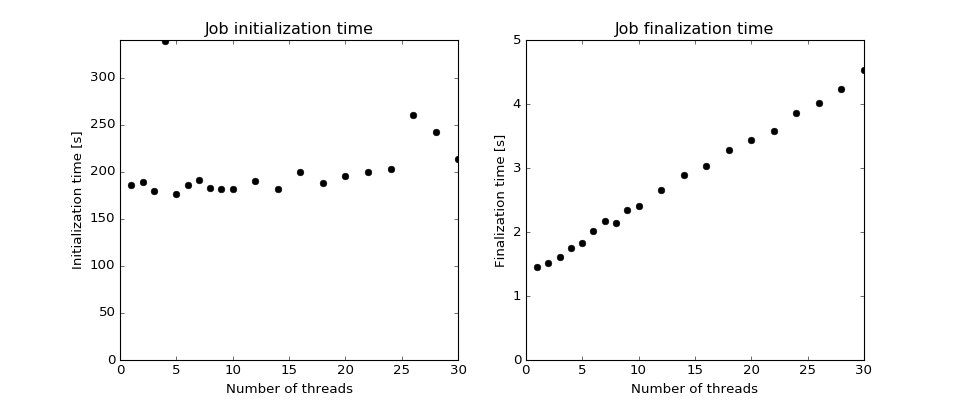

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(nThreads, init_times, 'ko')
plt.title('Job initialization time')
plt.ylim(ymin=0)
plt.xlabel('Number of threads')
plt.ylabel('Initialization time [s]')
plt.subplot(122)
plt.plot(nThreads, final_times, 'ko')
plt.title('Job finalization time')
plt.ylim(ymin=0)
plt.xlabel('Number of threads')
plt.ylabel('Finalization time [s]');

## Event throughput

Event throughput is arguably the most important result, so let's see how it scales with the number of threads. We calculate it by considering only the time in the event loop and the number of events processed. Then ideally the throughput should scale linearly with the number of threads

In [16]:
def get_throughput(job):
    """Calculate event throughput (events/s) for a job,
       ignoring initialization and finalization"""
    return job.nEvent / get_evloop_time(job)

<IPython.core.display.Javascript object>


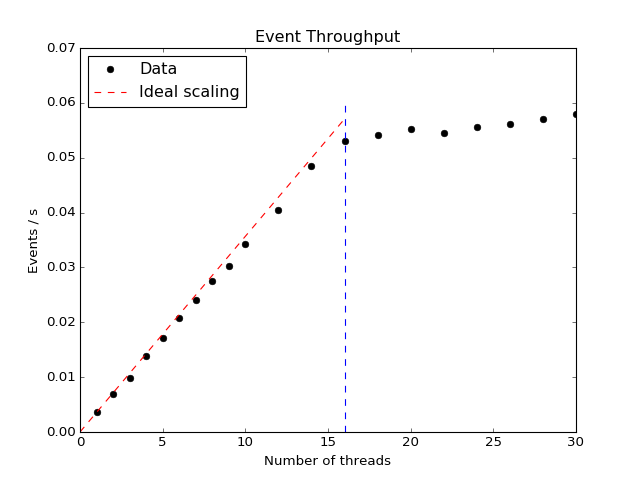

In [18]:
thruPuts = np.array([get_throughput(j) for j in job_results])
plt.figure()
plt.title('Event Throughput')
plt.plot(nThreads, thruPuts, 'ko', label='Data')
plt.xlabel('Number of threads')
plt.ylabel('Events / s')

# Draw ideal-scaling line, assuming 1-thread job as baseline
ideal_threads = np.array([0, 16])
ideal_thruput = ideal_threads * thruPuts[0]
plt.plot(ideal_threads, ideal_thruput, '--r', label='Ideal scaling')

# Draw vertical line at number of physical cores
cores_x, cores_y = [16, 16], [0, 0.06]
plt.plot(cores_x, cores_y, '--b')

plt.legend(loc=2, numpoints=1);

This looks very nice. Note this is a machine with 16 physical cores. The red line shows the ideal scaling relative to the 1-thread MT job. I do expect _some_ performance degradation at 16 cores because
* AthenaMT runs a few auxiliary threads for messaging and scheduling
* The memory monitor is running alongside the application using some of one core

## Memory scaling

Start with some helper functions for memory calculations, then plot memory footprint as a function of number of threads, as well as the memory in each job as a function of time.

In [19]:
def get_max_mem(job):
    """Calculate peak memory consumption in a job"""
    return job.times_mems['mems'].max()

<IPython.core.display.Javascript object>


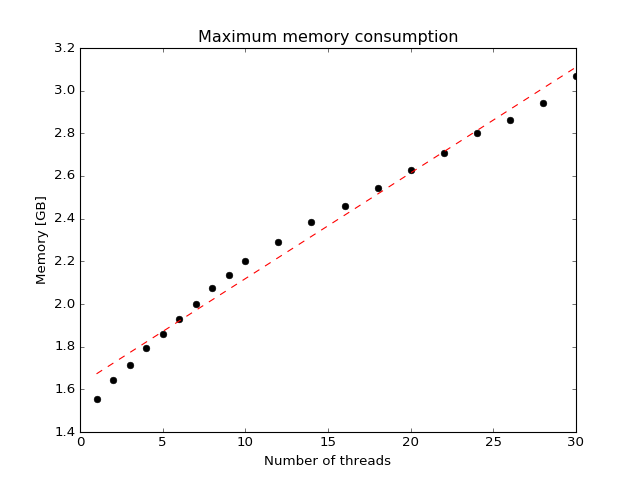

Memory fit: 1.62 GB + 49.56 MB/thread


In [20]:
maxMems = np.array([get_max_mem(j)*1e-6 for j in job_results])

# Fit a line to the data
fit = np.polyfit(nThreads, maxMems, 1)
fit_fn = np.poly1d(fit)

plt.figure()
plt.title('Maximum memory consumption')
plt.plot(nThreads, maxMems, 'ko', nThreads, fit_fn(nThreads), '--r')
plt.xlabel('Number of threads')
plt.ylabel('Memory [GB]')

print('Memory fit: {0:.2f} GB + {1:.2f} MB/thread'.format(fit[1], fit[0]*1e3))

<IPython.core.display.Javascript object>


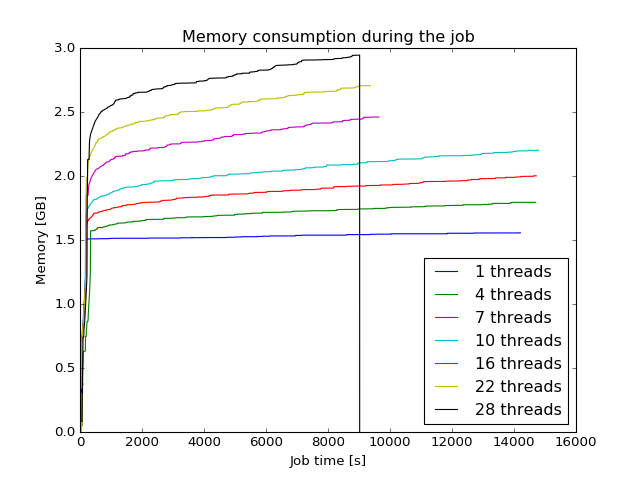

In [40]:
# Show memory as a function of job time
plt.figure()
plt.title('Memory consumption during the job')
for j in job_results[::3]:
    label = '%i threads' % j.nThread
    mems = j.times_mems['mems']*1e-6
    raw_times = j.times_mems['times']*1e-9
    times = raw_times - raw_times[0]
    plt.plot(times, mems, label=label)
plt.xlabel('Job time [s]')
plt.ylabel('Memory [GB]')
plt.legend(loc=4);

## Algorithm analysis

G4Hive currently has four algorithms:
* SGInputLoader populates the whiteboard with initial data
* BeamEffectsAlg applies some smearing effects to the generated event
* G4AtlasAlg runs Geant4 simulation on the smeared generated event
* StreamHITS writes the hit collections to output

Let's take a look at how the job breaks down by algorithm. We'd like to know how much time is spent in each algorithm and the timing distributions look for each alg.

I'm working on changing things up a little bit. Let's try to transform the data a bit beforehand so it will be easier to work with later. Compute the event-loop normalized timing results with durations.

In [21]:
def calc_alg_timings(job):
    """
    Transform the timeline results to be more useful.
    - Normalize start times to the beginning of event loop.
    - Calculate durations of each alg's execute
    - Store results converted to seconds as job.alg_starts, job.alg_durations
    """
    loop_start = get_evloop_start_time(job)
    raw_starts = job.timeline_results['starts']
    raw_ends = job.timeline_results['ends']
    job.alg_durations = (raw_ends - raw_starts)*1e-9
    job.alg_starts = (raw_starts - loop_start)*1e-9
    assert(job.alg_durations.min() >= 0)
    assert(job.alg_starts.min() >= 0)

def get_timeline_alg_idxs(job, alg):
    """Get the index array for one alg in the timeline"""
    return job.timeline_results['algs'] == alg

def get_timeline_thread_idxs(job, tid):
    """Get the index array for one thread ID in the timeline"""
    return job.timeline_results['tids'] == tid

def all_timeline_thread_idxs(job):
    """Get timeline results split by thread.
    Returns a list of timeline index arrays; one per thread"""
    tids = job.timeline_results['tids']
    unique_tids = np.unique(tids)
    return [get_timeline_thread_indices(job, tid) for tid in unique_tids]

In [22]:
# Prepare the alg timing results now
for job in job_results:
    calc_alg_timings(job)

Let's start with histograms of the duration of each algorithm. I want to see how the alg-time distribution varies with number of threads. I suspect the algorithms are taking longer with more threads because of some lock contention.

In [23]:
def get_alg_duration_map(job):
    """Returns dict of alg name to a list of execuion durations"""
    algs = job.timeline_results['algs']
    unique_algs = np.unique(algs)
    duration_map = {}
    for alg in unique_algs:
        indices = algs == alg
        duration_map[alg] = job.alg_durations[indices]
    return duration_map

In [24]:
alg_duration_maps = [get_alg_duration_map(j) for j in job_results]
g4alg_times = [m['G4AtlasAlg'] for m in alg_duration_maps]
loaderalg_times = [m['SGInputLoader'] for m in alg_duration_maps]
streamalg_times = [m['StreamHITS'] for m in alg_duration_maps]
beamalg_times = [m['BeamEffectsAlg'] for m in alg_duration_maps]

<IPython.core.display.Javascript object>


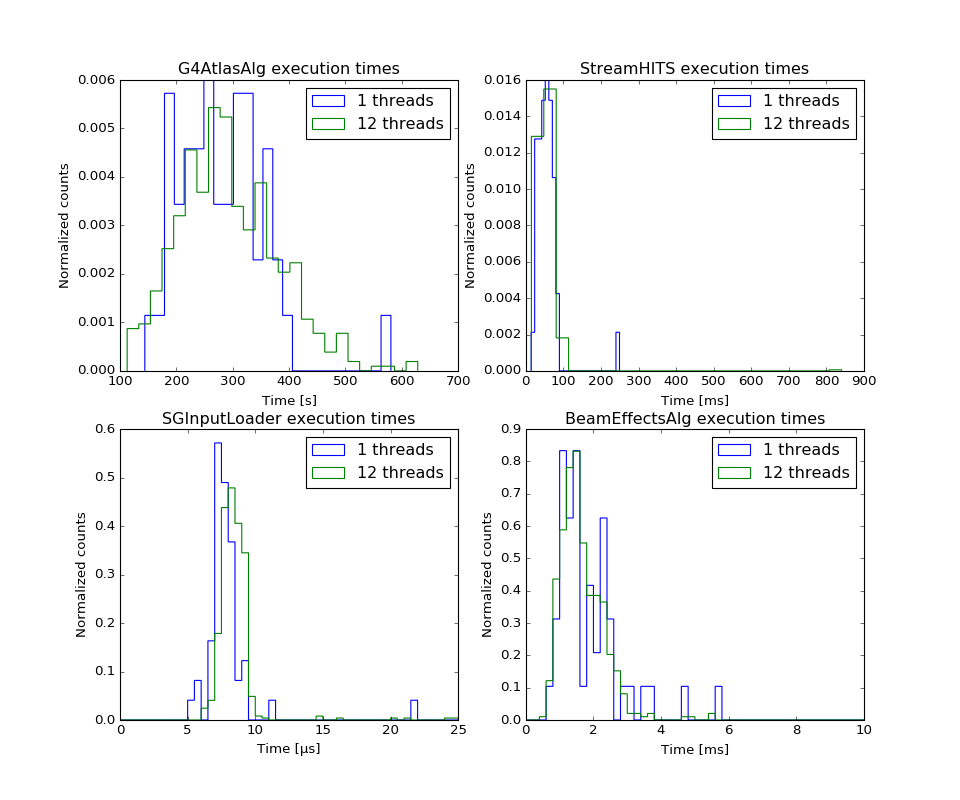

In [32]:
# Plot the histograms
plt.figure(figsize=(12, 10))

# The G4AtlasAlg timings
plt.subplot(221)
plt.title('G4AtlasAlg execution times')
skip = 10
for thread, times in zip(nThreads[0::skip], g4alg_times[0::skip]):
    label = '{0:d} threads'.format(thread)
    plt.hist(times, bins=25, histtype='step', label=label,
             normed=True, log=False)
plt.xlabel('Time [s]')
plt.ylabel('Normalized counts')
plt.legend()

# The StreamHITS timings
plt.subplot(222)
plt.title('StreamHITS execution times')
#skip=4
for thread, times in zip(nThreads[::skip], streamalg_times[::skip]):
    label = '{0:d} threads'.format(thread)
    plt.hist(times*1e3, bins=25, histtype='step',
             normed=True, label=label)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized counts')
plt.legend()

# The SGInputLoader timings
plt.subplot(223)
plt.title('SGInputLoader execution times')
#skip=10
for thread, times in zip(nThreads[::skip], loaderalg_times[::skip]):
    label = '{0:d} threads'.format(thread)
    plt.hist(times*1e6, bins=50, range=(0,25), histtype='step',
             normed=True, label=label)
plt.xlabel('Time [µs]')
plt.ylabel('Normalized counts')
plt.legend()

# The BeamEffectsAlg timings
plt.subplot(224)
plt.title('BeamEffectsAlg execution times')
#skip=4
for thread, times in zip(nThreads[::skip], beamalg_times[::skip]):
    label = '{0:d} threads'.format(thread)
    plt.hist(times*1e3, bins=50, range=(0, 10), histtype='step',
             normed=True, label=label)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized counts')
plt.legend();

For the next plot, I want to show how the total time in the event loop is broken down into algorithms and non-algorithmic time, where the latter includes scheduler overhead and waiting time. I think a stacked bar graph will service nicely here. Let's sum times across threads but normalize to the number of events. The total sum then is the inverse of the throughput.

Ok, so how do I get these results? I will likely want to break down the numbers in terms of each algorithm. I may need to restructure how I do the histograms above and the timeline below to reduce the amount of code and computation.

In [33]:
# A color map for the algorithms
alg_color_map = {'SGInputLoader' : 'yellow',
                 'BeamEffectsAlg' : 'blue',
                 'G4AtlasAlg' : 'red',
                 'StreamHITS' : 'green',
                 #'AthOutSeq' : 'yellow',
                 #'AthRegSeq' : 'purple',
                }

def get_time_sum_map(job_results, alg_duration_maps):
    """For each job, calculate the total time spent in each alg.
    Normalize by the number of events and organize the results
    into a list per alg in a dict."""
    time_sum_map = {}
    for j, dur_map in zip(job_results, alg_duration_maps):
        total_alg_time = 0.
        for alg, durs in dur_map.items():
            alg_time = durs.sum() / j.nEvent
            time_sum_map.setdefault(alg, []).append(alg_time)
    return time_sum_map

In [34]:
# Get the map of summed alg times
time_sum_map = get_time_sum_map(job_results, alg_duration_maps)
# Get the normalized total time in each job
total_time_sums = [get_evloop_time(j)*j.nThread/j.nEvent for j in job_results]

<IPython.core.display.Javascript object>


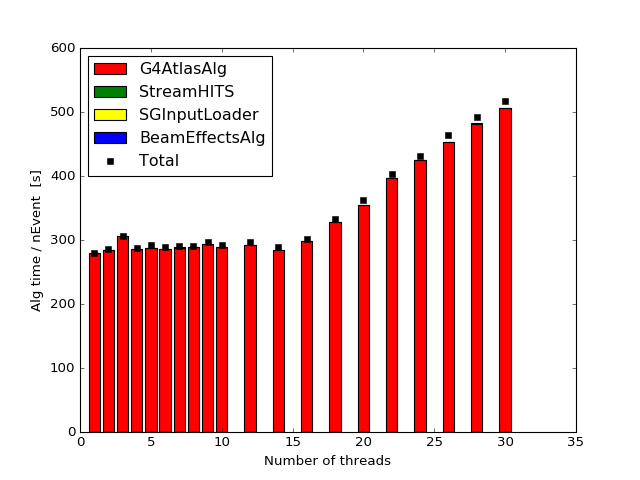

In [39]:
plt.figure()
algs = ['G4AtlasAlg', 'StreamHITS', 'SGInputLoader', 'BeamEffectsAlg']
colors = [alg_color_map[alg] for alg in algs]
leg_items = []
# Do the first one
x = plt.bar(nThreads, time_sum_map[algs[0]], color=colors[0], align='center')
leg_items.append(x[0])
# Do the rest
for i in range(1, len(algs)):
    x = plt.bar(nThreads, time_sum_map[algs[i]],
                bottom=time_sum_map[algs[i-1]],
                color=colors[i], align='center')
    leg_items.append(x[0])
x = plt.plot(nThreads, total_time_sums, 'sk', label='Total')
plt.ylabel('Alg time / nEvent  [s]')
plt.xlabel('Number of threads')
plt.legend(leg_items + [x[0]], algs + ['Total'], loc=2, numpoints=1);

## Event loop timeline

For the timeline plot, we'll split the results by thread in a bar graph.

In [36]:
class TimelineThreadData():
    """Simple struct for holding relevant timeline data in one thread"""
    def __init__(self, tid):
        self.tid = tid

def get_timeline_thread_data(job):
    """Get the processed timeline results per thread"""
    # Get the unique thread IDs
    tids = j.timeline_results['tids']
    unique_tids = np.unique(tids)
    assert(len(unique_tids) == j.nThread) # sanity check
    # Create and fill the per-thread timeline data
    ttds = [TimelineThreadData(tid) for tid in unique_tids]
    for ttd in ttds:
        indices = tids == ttd.tid
        algs = j.timeline_results['algs'][indices]
        ttd.colors = np.array([alg_color_map.get(alg, 'black') for alg in algs])
        starts = j.alg_starts[indices]
        durations = j.alg_durations[indices]
        ttd.times = np.column_stack((starts, durations))
    return ttds

In [37]:
# For the timeline plot, we'll look at just one job for now
j = job_results[3]

# Prepare timeline data split by thread ID
tldata_by_thread = get_timeline_thread_data(j)
unique_tids = np.unique(j.timeline_results['tids'])

<IPython.core.display.Javascript object>


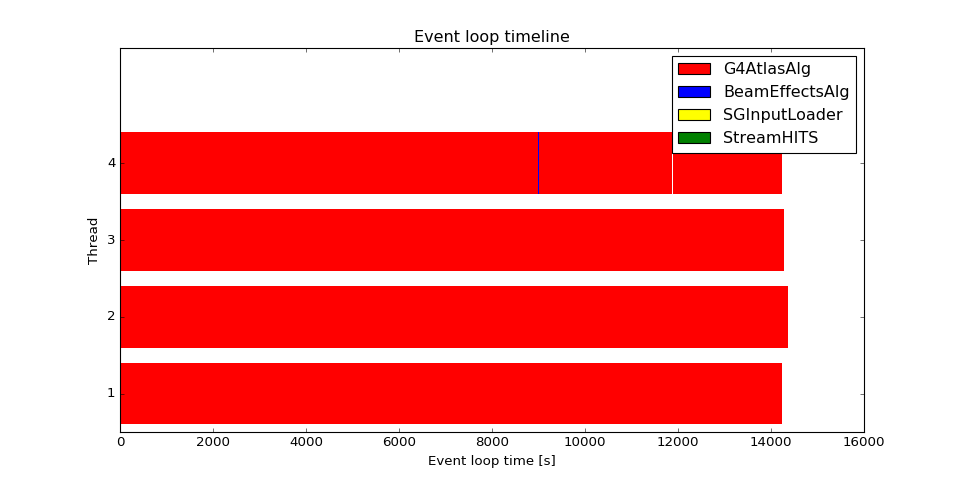

In [38]:
# Prepare the plot
plt.figure(figsize=(12, 6))
plt.title('Event loop timeline')
bar_thickness = 0.8
for i, tldata in enumerate(tldata_by_thread):
    ylow = (i + 1.) - bar_thickness/2
    plt.broken_barh(tldata.times, [ylow, bar_thickness], facecolors=tldata.colors, linewidth=0)
# Fake bar objects to populate the legend
legbars = [mpatch.Rectangle((0, 0), 1, 1, fc=c) for c in alg_color_map.values()]
plt.xlabel('Event loop time [s]')
plt.ylabel('Thread')
plt.yticks(range(1, len(unique_tids)+1))
plt.ylim(ymax=len(unique_tids)+1.5)
plt.xlim(xmin=0)
#plt.xlim(9, 9.1)
plt.legend(legbars, alg_color_map.keys(), loc=1);